# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from simulation import Simulation
from scipy.stats import lognorm
from scipy.special import i0
from analysis import calculate_autocorrelation, calculate_msd, fit_von_mises_mixture_mle, compute_turning_angles, compute_msd_dacf_per_movie

In [2]:
# # Set the style for Seaborn plots
# sns.set_theme(style="white", rc={"axes.labelsize": 22, "xtick.labelsize": 18, "ytick.labelsize": 18})
# sns.set_context("talk", font_scale=1.5)

# Get 4 distinct colors from Seaborn's Set2 palette
colors = sns.color_palette("colorblind", 4)

# Assign colors to each dataset
color_map = {
    "3D Manual Tracking": colors[1],
    "3D BTrack Tracking": colors[3], 
    "2D BTrack Tracking": colors[2],
    "NIH3T3": "grey",
    "Simulation": colors[0],
}

# Simulating without Experimental Data (Velocity and Turning Angles Distributions)

In [3]:
# from simulation import Simulation
# from visualization import plot_trajectories, create_animation, plot_cell_statistics
# from analysis import calculate_autocorrelation, calculate_msd

# # Create simulation with proper stadium parameters
# sim = Simulation(
#     n_cells=50,
#     stadium_L=800,          # Length of straight walls
#     stadium_R=200,          # Radius of semicircles
#     source_length=400,      # Length of gradient line source
#     chemotaxis_strength=0.0,
#     repulsion_strength=0.2,
#     starting_positions='perimeter'
# )

# # Run simulation
# sim.run(n_steps=100)

# # Visualize
# plot_trajectories(sim)
# plot_cell_statistics(sim)

# load data and fit distributions

In [4]:
# Load data
isolated_cells_data = pd.read_csv(r'D:\David\THESIS\tracks_dataframes\tracks_df_2025_01_22_2DFACS_FOXA2positive_lateday2.csv')
patterned_cells_data = pd.read_csv(r'D:\David\THESIS\tracks_dataframes\tracks_df_2024_09_09_FoxA2_tdTom_c211to300_BmpAct_day2To3.csv')
NIH3T3_cells_data = pd.read_csv(r'D:\David\THESIS\tracks_dataframes\tracks_df_2025_09_30_NIH3T3_migration_on_laminin.csv')

minimum_track_length = 50 
data = patterned_cells_data[['file', 'track_id', 't', 'normalized_time', 'x_microns', 'y_microns']]
data = data.groupby('track_id').filter(lambda x: len(x) >= minimum_track_length)
data['step'] = data.groupby('track_id').cumcount()
data['dx'] = data.groupby('track_id')['x_microns'].diff()
data['dy'] = data.groupby('track_id')['y_microns'].diff()
data['theta'] = np.arctan2(data['dy'], data['dx'])
data['dt'] = 5
data['v_x'] = data['dx'] / data['dt']
data['v_y'] = data['dy'] / data['dt']
data['velocity'] = np.sqrt(data['dx']**2 + data['dy']**2)/data['dt']
data['velocity'] = data['velocity'].replace([np.inf, -np.inf], np.nan)

# Fit a log-normal distribution to the velocity data
velocity_data = data['velocity'].dropna().values
velocity_data = velocity_data[velocity_data > 0]
shape, loc, scale = lognorm.fit(velocity_data, floc=0)
print(f"Fitted log-normal parameters: shape={shape}, loc={loc}, scale={scale}")

# Fit von Mises mixture model to turning angles
turning_angles = compute_turning_angles(data)
vonmises_params = fit_von_mises_mixture_mle(turning_angles)
print(f"Fitted von Mises mixture parameters: {vonmises_params}")

tracks = [group[['x_microns', 'y_microns']].values 
          for _, group in data.groupby('track_id')]

Fitted log-normal parameters: shape=0.7700315866974897, loc=0, scale=0.2802353573838469
Fitted von Mises mixture parameters: {'params': {'W1': np.float64(0.7850139204062415), 'kappa1': np.float64(0.0), 'kappa2': np.float64(2.6542212269715684)}, 'success': True, 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'nll': np.float64(97311.38894860668)}


Text(0, 0.5, 'Density')

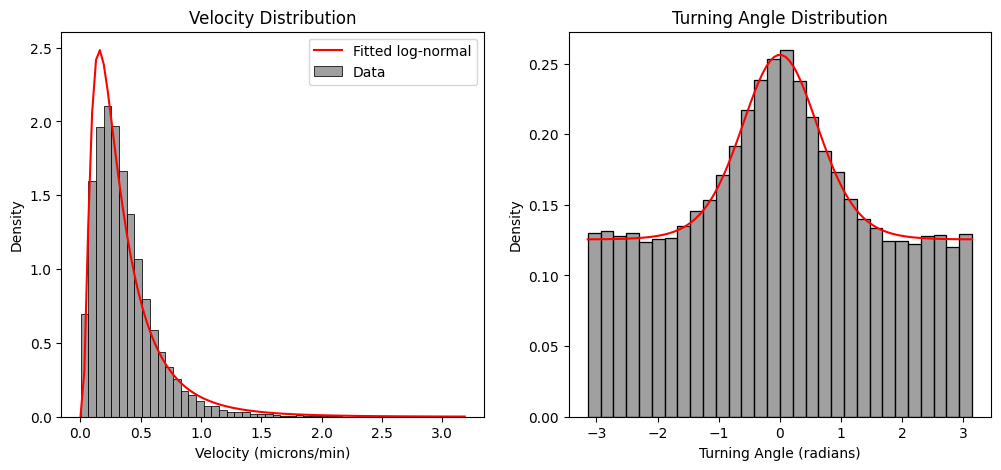

In [5]:
# plot one figure with velocity distribution and turning angle distribution and fitted curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Velocity distribution
sns.histplot(velocity_data, bins=50, kde=False, stat='density', ax=axes[0], color='gray', label='Data')
x = np.linspace(0, velocity_data.max(), 100)
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale)
axes[0].plot(x, pdf_fitted, 'r-', label='Fitted log-normal')
axes[0].set_title('Velocity Distribution')
axes[0].set_xlabel('Velocity (microns/min)')
axes[0].set_ylabel('Density')
axes[0].legend()
# Turning angle distribution
sns.histplot(turning_angles, bins=30, kde=False, stat='density', ax=axes[1], color='gray', label='Data')
x_angles = np.linspace(-np.pi, np.pi, 100)
pdf_fitted_angles = (vonmises_params['params']['W1'] * 
                     (np.exp(vonmises_params['params']['kappa1'] * np.cos(x_angles)) / (2 * np.pi * i0(vonmises_params['params']['kappa1']))) +
                     (1 - vonmises_params['params']['W1']) * 
                     (np.exp(vonmises_params['params']['kappa2'] * np.cos(x_angles)) / (2 * np.pi * i0(vonmises_params['params']['kappa2']))))
axes[1].plot(x_angles, pdf_fitted_angles, 'r-', label='Fitted von Mises mixture')
axes[1].set_title('Turning Angle Distribution')
axes[1].set_xlabel('Turning Angle (radians)')
axes[1].set_ylabel('Density')

# Simulate

In [6]:
# Run simulation
sim = Simulation(
    n_cells=300,
    time_step=5, # time step in minutes
    stadium_L=800,
    stadium_R=200,
    source_length=400,
    chemotaxis_strength=0.3,
    repulsion_strength=0.0, # the default is no cell-cell repulsion
    interaction_radius=0.0, 
    velocity_params={'shape': shape, 'loc': loc, 'scale': scale}, # parameters of the log-normal distribution fitted to the data
    persistence=0.1,
    starting_positions='perimeter', # Initial positions distribution for cells: 'perimeter' or 'uniform'
    mode='biased_persistent', # Simulation mode: 'random', 'persistent', 'biased_persistent', 'uniform_memory', 'exp_memory', 'power_memory'
    # Memory parameters (only used if mode is 'uniform_memory', 'exp_memory', or 'power_memory')
    memory_window=None, 
    memory_exp_lambda=0.1,
    memory_power_alpha=1.5, # power-law exponent for power_memory mode
    vonmises_params=vonmises_params['params'])

sim.run(n_steps=data['step'].max())
sim_df = sim.get_dataframe()

Step 25/288 completed
Step 50/288 completed
Step 75/288 completed
Step 100/288 completed
Step 125/288 completed
Step 150/288 completed
Step 175/288 completed
Step 200/288 completed
Step 225/288 completed
Step 250/288 completed
Step 275/288 completed
Simulation completed: 288 steps


In [7]:
from visualization import plot_trajectories, create_animation, plot_cell_statistics

# Plot trajectories
# plot_trajectories(sim, show_gradient=False)

# # Create animation
# anim = create_animation(sim, save_path='migration.gif')

# Plot statistics
# plot_cell_statistics(sim)

In [8]:
msd_exp, dacf_exp = compute_msd_dacf_per_movie(data, x_col='x_microns', y_col='y_microns', max_lag=None)

msd_sim, dacf_sim = calculate_msd(sim_df, x_col='x', y_col='y'), calculate_autocorrelation(sim_df)

# Fit

In [9]:
# from fit import fit_grid

exp_df = patterned_cells_data.copy()
exp_df = exp_df.groupby('track_id').filter(lambda x: len(x) >= minimum_track_length)
exp_df['step'] = exp_df.groupby('track_id').cumcount()
exp_df['dx'] = exp_df.groupby('track_id')['x_microns'].diff()
exp_df['dy'] = exp_df.groupby('track_id')['y_microns'].diff()
exp_df['velocity'] = np.sqrt(exp_df['dx']**2 + exp_df['dy']**2)/5  # Assuming dt=10 as in experimental data
exp_df['v_x'] = exp_df['dx'] / 5
exp_df['v_y'] = exp_df['dy'] / 5
exp_df['x'] = exp_df['x_microns']
exp_df['y'] = exp_df['y_microns']

# fit velocity distribution
velocity_data = exp_df['velocity'].dropna().values
velocity_data = velocity_data[velocity_data > 0]
shape, loc, scale = lognorm.fit(velocity_data, floc=0)

# # Define parameter grid for fitting
# params_grid = {
#     'memory_power_alpha': np.linspace(0.3, 2, 3),
#     # 'memory_exp_lambda': np.linspace(0.01, 0.5, 10),
#     'memory_window': [5, 10],
#     'chemotaxis_strength': [0.2]
# }

# # options for simulation_mode: 'random', 'persistent', 'biased_persistent', 'uniform_memory', 'exp_memory', 'power_memory', 'persistent_chemotaxis'
# best, table = fit_grid(exp_df,
#                        simulation_mode='power_memory',
#                        param_grid=params_grid,
#                        velocity_dist_params={'shape': shape, 'loc': loc, 'scale': scale},
#                        vonmises_params=vonmises_params['params'],
#                        chi_weight=0.5,
#                        n_steps=289,
#                        n_cells=200)

# print("Best parameters:", best)

In [10]:
# tbl = table.copy()
# tbl['memory_power_alpha'] = tbl['memory_power_alpha'].round(2)
# tbl['memory_window'] = tbl['memory_window'].round(2)
# tbl['chemotaxis_strength'] = tbl['chemotaxis_strength'].round(2)

In [11]:
# # round persistence and chemotaxis_strength to 2 decimals and plot heatmaps

# # CHOOSE SUBSET OF POWER ALPHA AND MEMORY WINDOW
# tbl = tbl[(tbl['memory_power_alpha'].between(1.3, 2.0)) &
#           (tbl['memory_window'].between(5, 300))]
# tbl['memory_power_alpha'] = tbl['memory_power_alpha'].round(2)
# tbl['memory_window'] = tbl['memory_window'].round(2)

# # log scale
# # tbl['chi2_dacf'] = np.log(tbl['chi2_dacf'])
# # tbl['chi2_msd'] = np.log(tbl['chi2_msd'])
# # tbl['score'] = np.log(tbl['score'])

# # log scale heatmaps
# fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# # Big title
# # plt.suptitle('Log Scale Heatmaps of Chi-squared Values', fontsize=25)

# sns.heatmap(table_pivot_dacf, ax=axes[0], cmap='viridis', annot=False, fmt='.2f')
# axes[0].set_title('Chi-squared DACF')
# axes[0].set_xlabel('Memory Window')
# axes[0].set_ylabel('Memory Exp Lambda')
# axes[0].set_xticks(np.arange(len(table_pivot_dacf.columns)) + 0.5)
# axes[0].set_xticklabels([f"{c:.2f}" for c in table_pivot_dacf.columns], rotation=90, fontsize=16)
# axes[0].set_yticks(np.arange(len(table_pivot_dacf.index)) + 0.5)
# axes[0].set_yticklabels([f"{i:.2f}" for i in table_pivot_dacf.index], rotation=0, fontsize=16)

# sns.heatmap(table_pivot_msd, ax=axes[1], cmap='viridis', annot=False, fmt='.2f')
# axes[1].set_title('Chi-squared MSD')
# axes[1].set_xlabel('Memory Window')
# axes[1].set_ylabel('')
# axes[1].set_xticks(np.arange(len(table_pivot_msd.columns)) + 0.5)
# axes[1].set_xticklabels([f"{c:.2f}" for c in table_pivot_msd.columns], rotation=90, fontsize=16)
# axes[1].set_yticks(np.arange(len(table_pivot_msd.index)) + 0.5)
# axes[1].set_yticklabels([])

# sns.heatmap(table_pivot_total, ax=axes[2], cmap='viridis', annot=False, fmt='.2f')
# axes[2].set_title('Total Chi-squared')
# axes[2].set_xlabel('Memory Window')
# axes[2].set_ylabel('')
# axes[2].set_xticks(np.arange(len(table_pivot_total.columns)) + 0.5)
# axes[2].set_xticklabels([f"{c:.2f}" for c in table_pivot_total.columns], rotation=90, fontsize=16)
# axes[2].set_yticks(np.arange(len(table_pivot_total.index)) + 0.5)
# axes[2].set_yticklabels([])

# plt.tight_layout()
# plt.show()

In [12]:
# tbl['persistence'] = tbl['persistence'].round(2)

# # plot chi as a function of persistence
# fig, ax = plt.subplots(figsize=(8, 8))
# sns.lineplot(data=tbl, x='persistence', y='chi2_dacf', marker='o', ax=ax, label='Chi-squared DACF', linewidth=2)
# sns.lineplot(data=tbl, x='persistence', y='chi2_msd', marker='o', ax=ax, color='orange', label='Chi-squared MSD', linewidth=2)
# plt.xlabel('Persistence')
# plt.ylabel('Chi-squared Score')
# plt.legend()
# ax.set_title('Chi-squared Score vs Persistence')

In [13]:
# # plot the chi-squared values for chemotaxis_strength=0.0 as a function of persistence
# chemotaxis_fixed = 0.0
# subset = tbl[tbl['chemotaxis_strength'] == chemotaxis_fixed]
# subset = subset.sort_values(by='persistence')
# plt.figure(figsize=(8, 6))
# # plt.scatter(subset['persistence'][:-1], subset['chi2_dacf'][:-1], marker='o', label='Chi-squared DACF', color='blue')
# # plt.scatter(subset['persistence'][:-1], subset['chi2_msd'][:-1], marker='o', label='Chi-squared MSD', color='orange')
# plt.plot(subset['persistence'][:-1], subset['score'][:-1], marker='o', label='Total Score', color='k', markersize=8, linewidth=3)
# plt.ylim(0, 20.5)
# plt.xlabel('Persistence')
# plt.ylabel('Chi-squared Value')

In [14]:
# plot best simulation vs experimental data
best_sim = Simulation(
    n_cells=200,
    time_step=5, # time step in minutes
    stadium_L=800,
    stadium_R=200,
    source_length=400,
    chemotaxis_strength=0.3,
    repulsion_strength=0.0, # the default is no cell-cell repulsion
    interaction_radius=0.0, 
    velocity_params={'shape': shape, 'loc': loc, 'scale': scale}, # parameters of the log-normal distribution fitted to the data
    persistence=0.2,
    starting_positions='perimeter', # Initial positions distribution for cells: 'perimeter' or 'uniform'
    mode='biased_persistent', # Simulation mode: 'random', 'persistent', 'biased_persistent', 'uniform_memory', 'exp_memory', 'power_memory'
    # Memory parameters (only used if mode is 'uniform_memory', 'exp_memory', or 'power_memory')
    memory_window=None,
    memory_exp_lambda=0.0, 
    memory_power_alpha=1.5, # power-law exponent for power_memory mode
    vonmises_params=vonmises_params['params'])

best_sim.run(n_steps=289)
best_sim_df = best_sim.get_dataframe()

Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


In [15]:
# Plot trajectories
# plot_trajectories(best_sim, show_gradient=False)

# # Create animation
# anim = create_animation(best_sim, save_path='migration.gif')

# Plot statistics
# plot_cell_statistics(best_sim)

In [16]:
msd_exp, dacf_exp = compute_msd_dacf_per_movie(exp_df, max_lag=None)

best_sim_dacf = calculate_autocorrelation(best_sim_df)
best_sim_msd = calculate_msd(best_sim_df, x_col='x', y_col='y')

In [17]:
# fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# # DACF plot
# n_memory = 10  # Number of memory steps 
# axes[0].scatter(dacf_exp['lag'], dacf_exp['dacf'], label='Experiment', color=color_map["2D BTrack Tracking"], marker='o')
# axes[0].scatter(best_sim_dacf['lag'][:n_memory], best_sim_dacf['dacf'][:n_memory], label='Simulation (memory)', color='red', marker='o')
# axes[0].scatter(best_sim_dacf['lag'][n_memory:], best_sim_dacf['dacf'][n_memory:], label='Simulation (guess)', facecolors='none', edgecolors='red', marker='o')
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
# axes[0].set_xlabel('Lag')
# axes[0].set_ylabel('DACF')
# axes[0].set_title('Directional Autocorrelation')
# axes[0].legend()

# # MSD plot
# axes[1].scatter(msd_exp['lag'], msd_exp['msd'], label='Experiment', color=color_map["2D BTrack Tracking"], marker='o')
# axes[1].scatter(best_sim_msd['lag'][:n_memory], best_sim_msd['msd'][:n_memory], label='Simulation (memory)', color='red', marker='o')
# axes[1].scatter(best_sim_msd['lag'][n_memory:], best_sim_msd['msd'][n_memory:], label='Simulation (guess)', facecolors='none', edgecolors='red', marker='o')
# axes[1].set_xscale('log')
# axes[1].set_yscale('log')
# axes[1].grid(True, which='major', linestyle='--', linewidth=0.5)
# axes[1].set_xlabel('Lag')
# axes[1].set_ylabel('MSD')
# axes[1].set_title('Mean Squared Displacement')
# axes[1].legend()

# plt.tight_layout()
# plt.show()

In [18]:
# Set the style for Seaborn plots
sns.set_theme(style="white", rc={"axes.labelsize": 22, "xtick.labelsize": 18, "ytick.labelsize": 18})
sns.set_context("paper", font_scale=3)

Chi-squared DACF: 18.6276
Chi-squared MSD: 1.5033


C:\Users\davidzi\AppData\Local\Temp\ipykernel_19556\1222982506.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


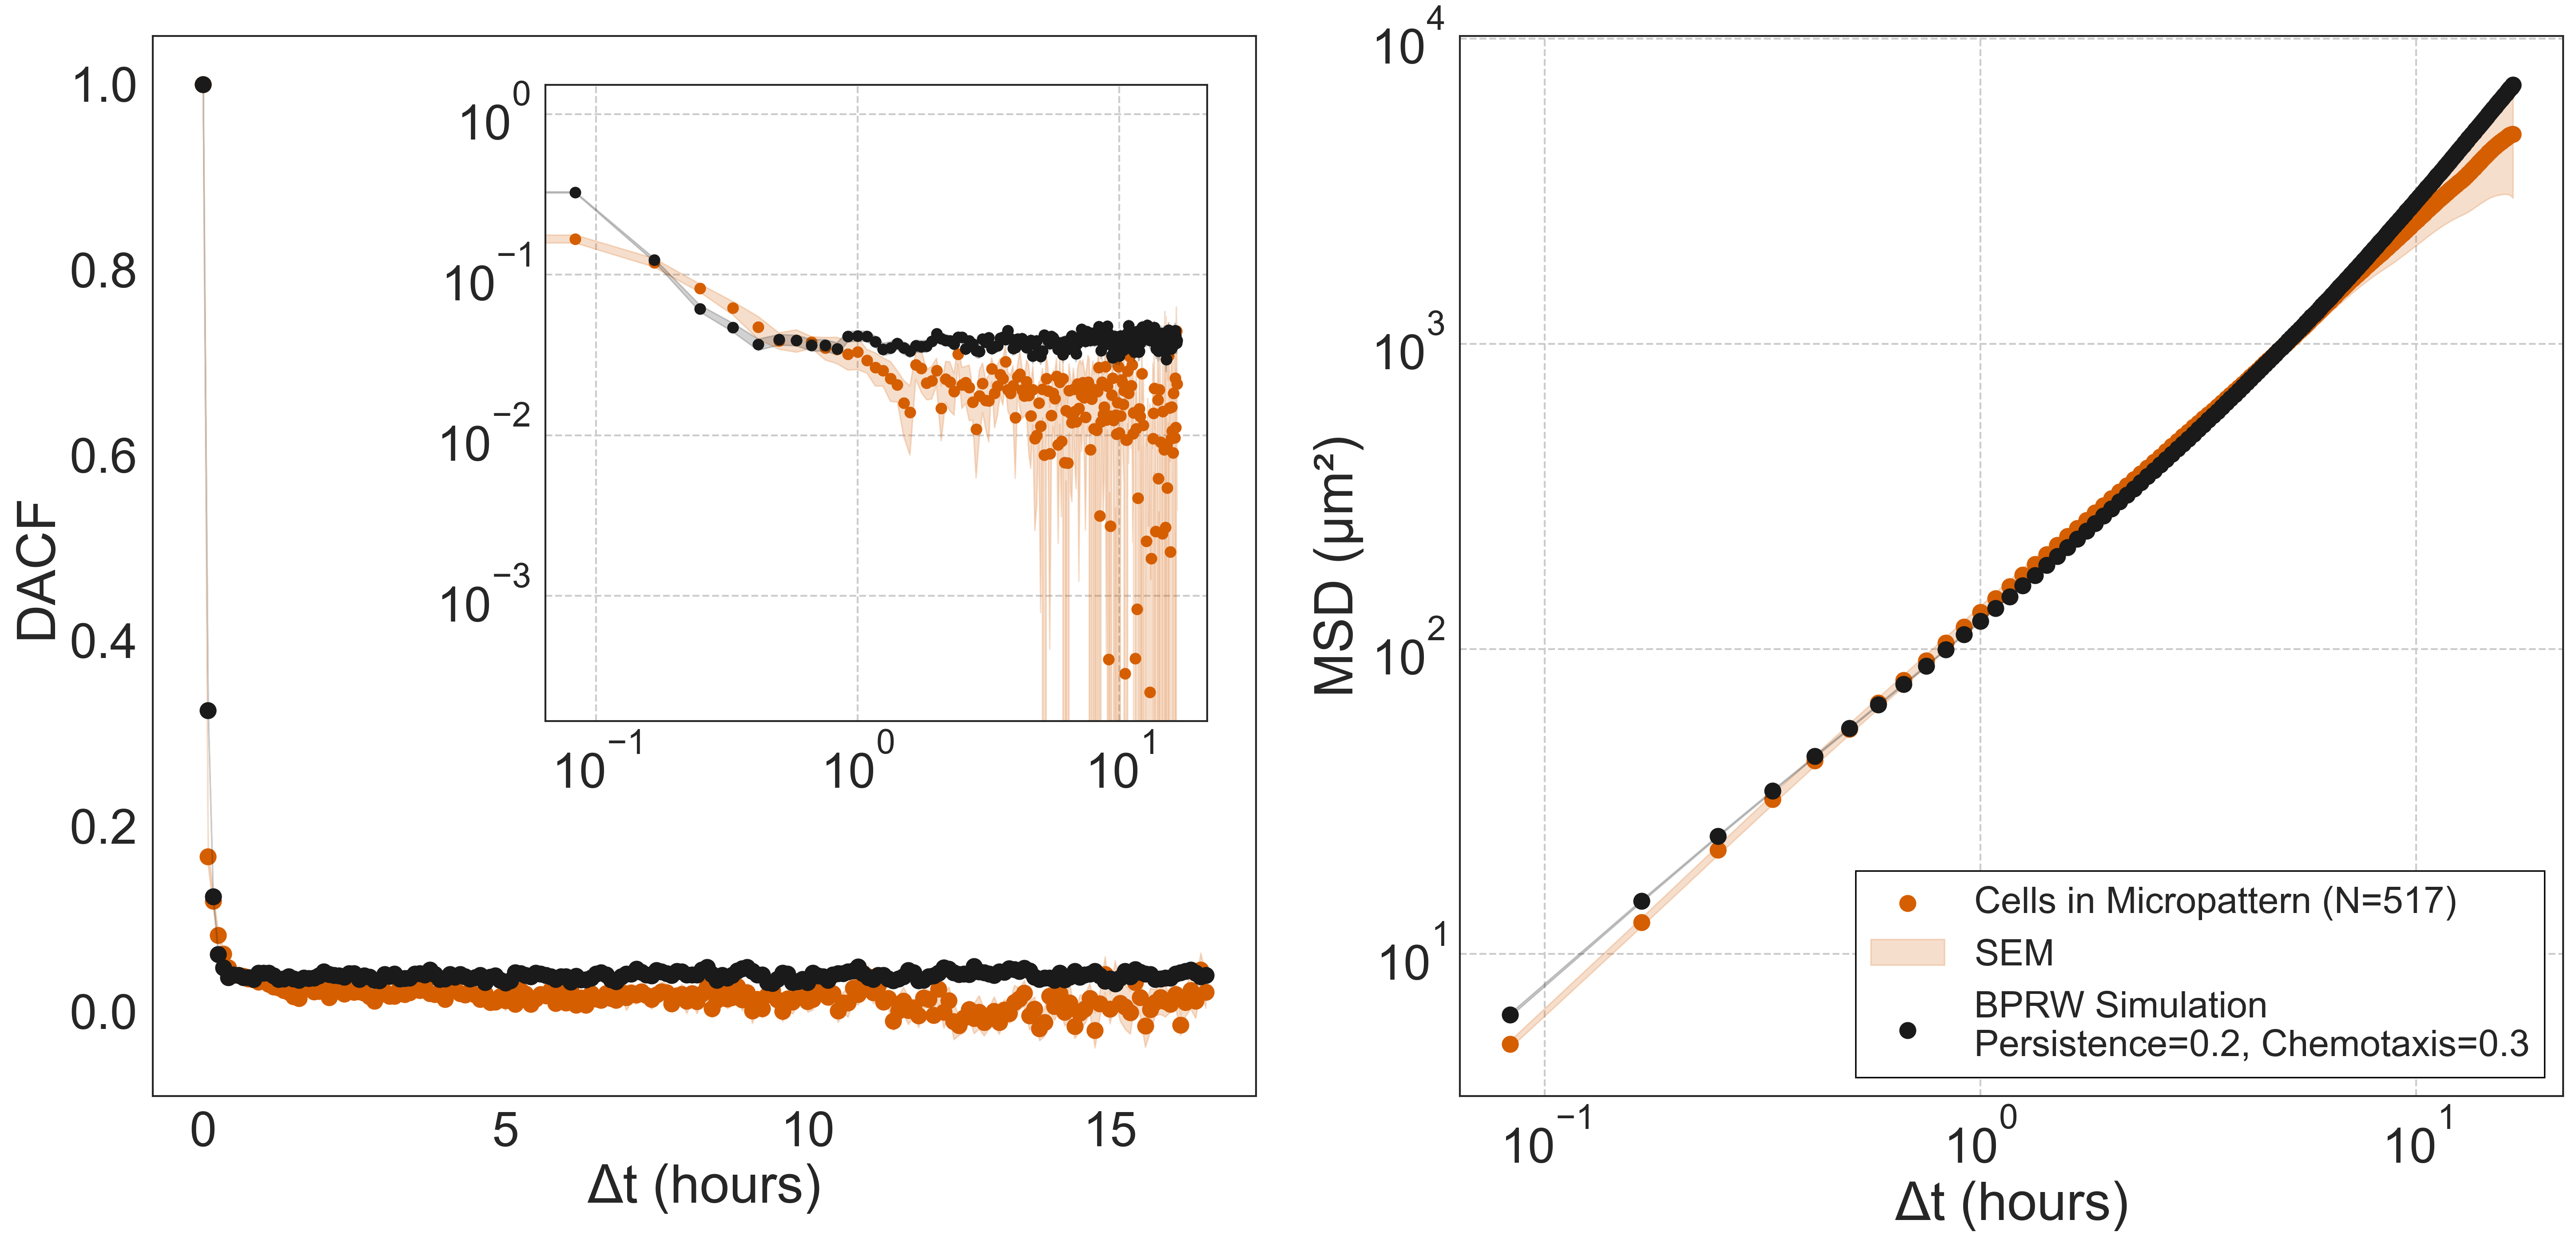

In [19]:
# calculate chi squared values for DACF and MSD
from fit import reduced_chi_squared
chi2_dacf = reduced_chi_squared(dacf_exp['dacf_mean'][:20], best_sim_dacf['dacf'][:20], dacf_exp['dacf_sem'][:20])
chi2_msd = reduced_chi_squared(msd_exp['msd_mean'][:200], best_sim_msd['msd'][:200], msd_exp['msd_sem'][:200])
print(f"Chi-squared DACF: {chi2_dacf:.4f}")
print(f"Chi-squared MSD: {chi2_msd:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=300)

points_to_plot = 200  # Number of points to plot for DACF and MSD
color = color_map['3D BTrack Tracking']
simulation_label = f'BPRW Simulation' + '\n' + f'Persistence={best_sim.persistence}, Chemotaxis={best_sim.chemotaxis_strength}'
data_label = f'Cells in Micropattern (N={data["track_id"].nunique()})'

# Convert dt from minutes to hours for plotting (use same slicing as points_to_plot)
dacf_dt_hours = dacf_exp['dt'][:points_to_plot] / 60.0
best_sim_dacf_dt_hours = best_sim_dacf['dt'][:points_to_plot] / 60.0
msd_dt_hours = msd_exp['dt'][:points_to_plot] / 60.0
best_sim_msd_dt_hours = best_sim_msd['dt'][:points_to_plot] / 60.0

#
axes[0].scatter(dacf_dt_hours, dacf_exp['dacf_mean'][:points_to_plot], label=data_label, color=color, marker='o', s=70)
axes[0].fill_between(dacf_dt_hours,
                     dacf_exp['dacf_mean'][:points_to_plot] - dacf_exp['dacf_sem'][:points_to_plot],
                     dacf_exp['dacf_mean'][:points_to_plot] + dacf_exp['dacf_sem'][:points_to_plot],
                     color=color, alpha=0.2, label='SEM')
axes[0].scatter(best_sim_dacf_dt_hours, best_sim_dacf['dacf'][:points_to_plot], label=simulation_label, color='k', marker='o', s=70)
axes[0].fill_between(best_sim_dacf_dt_hours,
                     best_sim_dacf['dacf'][:points_to_plot] - best_sim_dacf['dacf_sem'][:points_to_plot],
                     best_sim_dacf['dacf'][:points_to_plot] + best_sim_dacf['dacf_sem'][:points_to_plot],
                     color='k', alpha=0.2)
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
# axes[0].grid(True, which='major', linestyle='--', linewidth=1)
axes[0].set_xlabel('Δt (hours)')
axes[0].set_ylabel('DACF')
# axes[0].set_title('Directional Autocorrelation')
# axes[0].legend(loc='upper right', frameon=1, fontsize=23, edgecolor='black', fancybox=False, framealpha=1)

# Add inset to DACF plot to show loglog
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(axes[0], width="60%", height="60%", loc='upper right', borderpad=1)
axins.scatter(dacf_dt_hours, dacf_exp['dacf_mean'][:points_to_plot], label=data_label, color=color, marker='o', s=30)
axins.fill_between(dacf_dt_hours,
                   dacf_exp['dacf_mean'][:points_to_plot] - dacf_exp['dacf_sem'][:points_to_plot],
                   dacf_exp['dacf_mean'][:points_to_plot] + dacf_exp['dacf_sem'][:points_to_plot],
                   color=color, alpha=0.2, label='SEM')
axins.scatter(best_sim_dacf_dt_hours, best_sim_dacf['dacf'][:points_to_plot], label=simulation_label, color='k', marker='o', s=30)
axins.fill_between(best_sim_dacf_dt_hours,
                   best_sim_dacf['dacf'][:points_to_plot] - best_sim_dacf['dacf_sem'][:points_to_plot],
                   best_sim_dacf['dacf'][:points_to_plot] + best_sim_dacf['dacf_sem'][:points_to_plot],
                   color='k', alpha=0.2)
axins.grid(True, which='major', linestyle='--', linewidth=1)
axins.set_xscale('log')
axins.set_yscale('log')

# MSD plot (x axis in hours now)
axes[1].scatter(msd_dt_hours, msd_exp['msd_mean'][:points_to_plot], label=data_label, color=color, marker='o', s=70)
# plot standard error of the mean as shaded area
axes[1].fill_between(msd_dt_hours,
                     msd_exp['msd_mean'][:points_to_plot] - msd_exp['msd_sem'][:points_to_plot],
                     msd_exp['msd_mean'][:points_to_plot] + msd_exp['msd_sem'][:points_to_plot],
                     color=color, alpha=0.2, label='SEM')
axes[1].scatter(best_sim_msd_dt_hours, best_sim_msd['msd'][:points_to_plot], label=simulation_label, color='k', marker='o', s=70)
axes[1].fill_between(best_sim_msd_dt_hours,
                     best_sim_msd['msd'][:points_to_plot] - best_sim_msd['msd_sem'][:points_to_plot],
                     best_sim_msd['msd'][:points_to_plot] + best_sim_msd['msd_sem'][:points_to_plot],
                     color='k', alpha=0.2)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True, which='major', linestyle='--', linewidth=1)
axes[1].set_xlabel('Δt (hours)')
axes[1].set_ylabel('MSD (μm²)')
# axes[1].set_title('Mean Squared Displacement')
axes[1].legend(loc='lower right', frameon=True, fontsize=20, edgecolor='black', fancybox=False, framealpha=1)

# legend below plots
# Move legend below the plots, outside the axes
handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True, fontsize=24, edgecolor='black', fancybox=False, framealpha=1, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

# Fit Memory

In [ ]:
n_cells = 200
n_steps = 289
time_step = 5
memory_power_alpha = 1.51

# Power-law memory sweep: vary memory_window and compare DACF/MSD to experimental (exp_df)
memory_windows_hours = [1/12, 1, 2, 4, 8]  # None means infinite memory
memory_windows = [int(w * 60 / time_step) for w in memory_windows_hours]
# memory_windows = np.linspace(1, 289, 101, dtype=int).tolist() + [n_steps]

results = {}
for w in memory_windows:
    sim_w = Simulation(
        n_cells=n_cells,
        time_step=time_step,
        stadium_L=8000,
        stadium_R=2000,
        source_length=400,
        chemotaxis_strength=0.0,
        repulsion_strength=0.0,
        interaction_radius=0.0,
        velocity_params={'shape': shape, 'loc': loc, 'scale': scale},
        persistence=0.0,
        starting_positions='uniform',
        mode='power_memory',
        memory_window=w,
        memory_exp_lambda=0.1,
        memory_power_alpha=memory_power_alpha,
        vonmises_params=vonmises_params['params']
    )
    sim_w.run(n_steps=n_steps)
    sim_df_w = sim_w.get_dataframe()
    msd_w = calculate_msd(sim_df_w, x_col='x', y_col='y')
    dacf_w = calculate_autocorrelation(sim_df_w)
    results[w] = {'sim': sim_w, 'df': sim_df_w, 'msd': msd_w, 'dacf': dacf_w}


Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


d:\David\THESIS\simulation\MCmigrate\analysis.py:57: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(norm_dot)
c:\Users\davidzi\AppData\Local\anaconda3\envs\simulations-env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


d:\David\THESIS\simulation\MCmigrate\analysis.py:57: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(norm_dot)
c:\Users\davidzi\AppData\Local\anaconda3\envs\simulations-env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


d:\David\THESIS\simulation\MCmigrate\analysis.py:57: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(norm_dot)
c:\Users\davidzi\AppData\Local\anaconda3\envs\simulations-env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


d:\David\THESIS\simulation\MCmigrate\analysis.py:57: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(norm_dot)
c:\Users\davidzi\AppData\Local\anaconda3\envs\simulations-env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


d:\David\THESIS\simulation\MCmigrate\analysis.py:57: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(norm_dot)
c:\Users\davidzi\AppData\Local\anaconda3\envs\simulations-env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


C:\Users\davidzi\AppData\Local\Temp\ipykernel_22608\2980051340.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.3, 1, 1])  # leave space for both


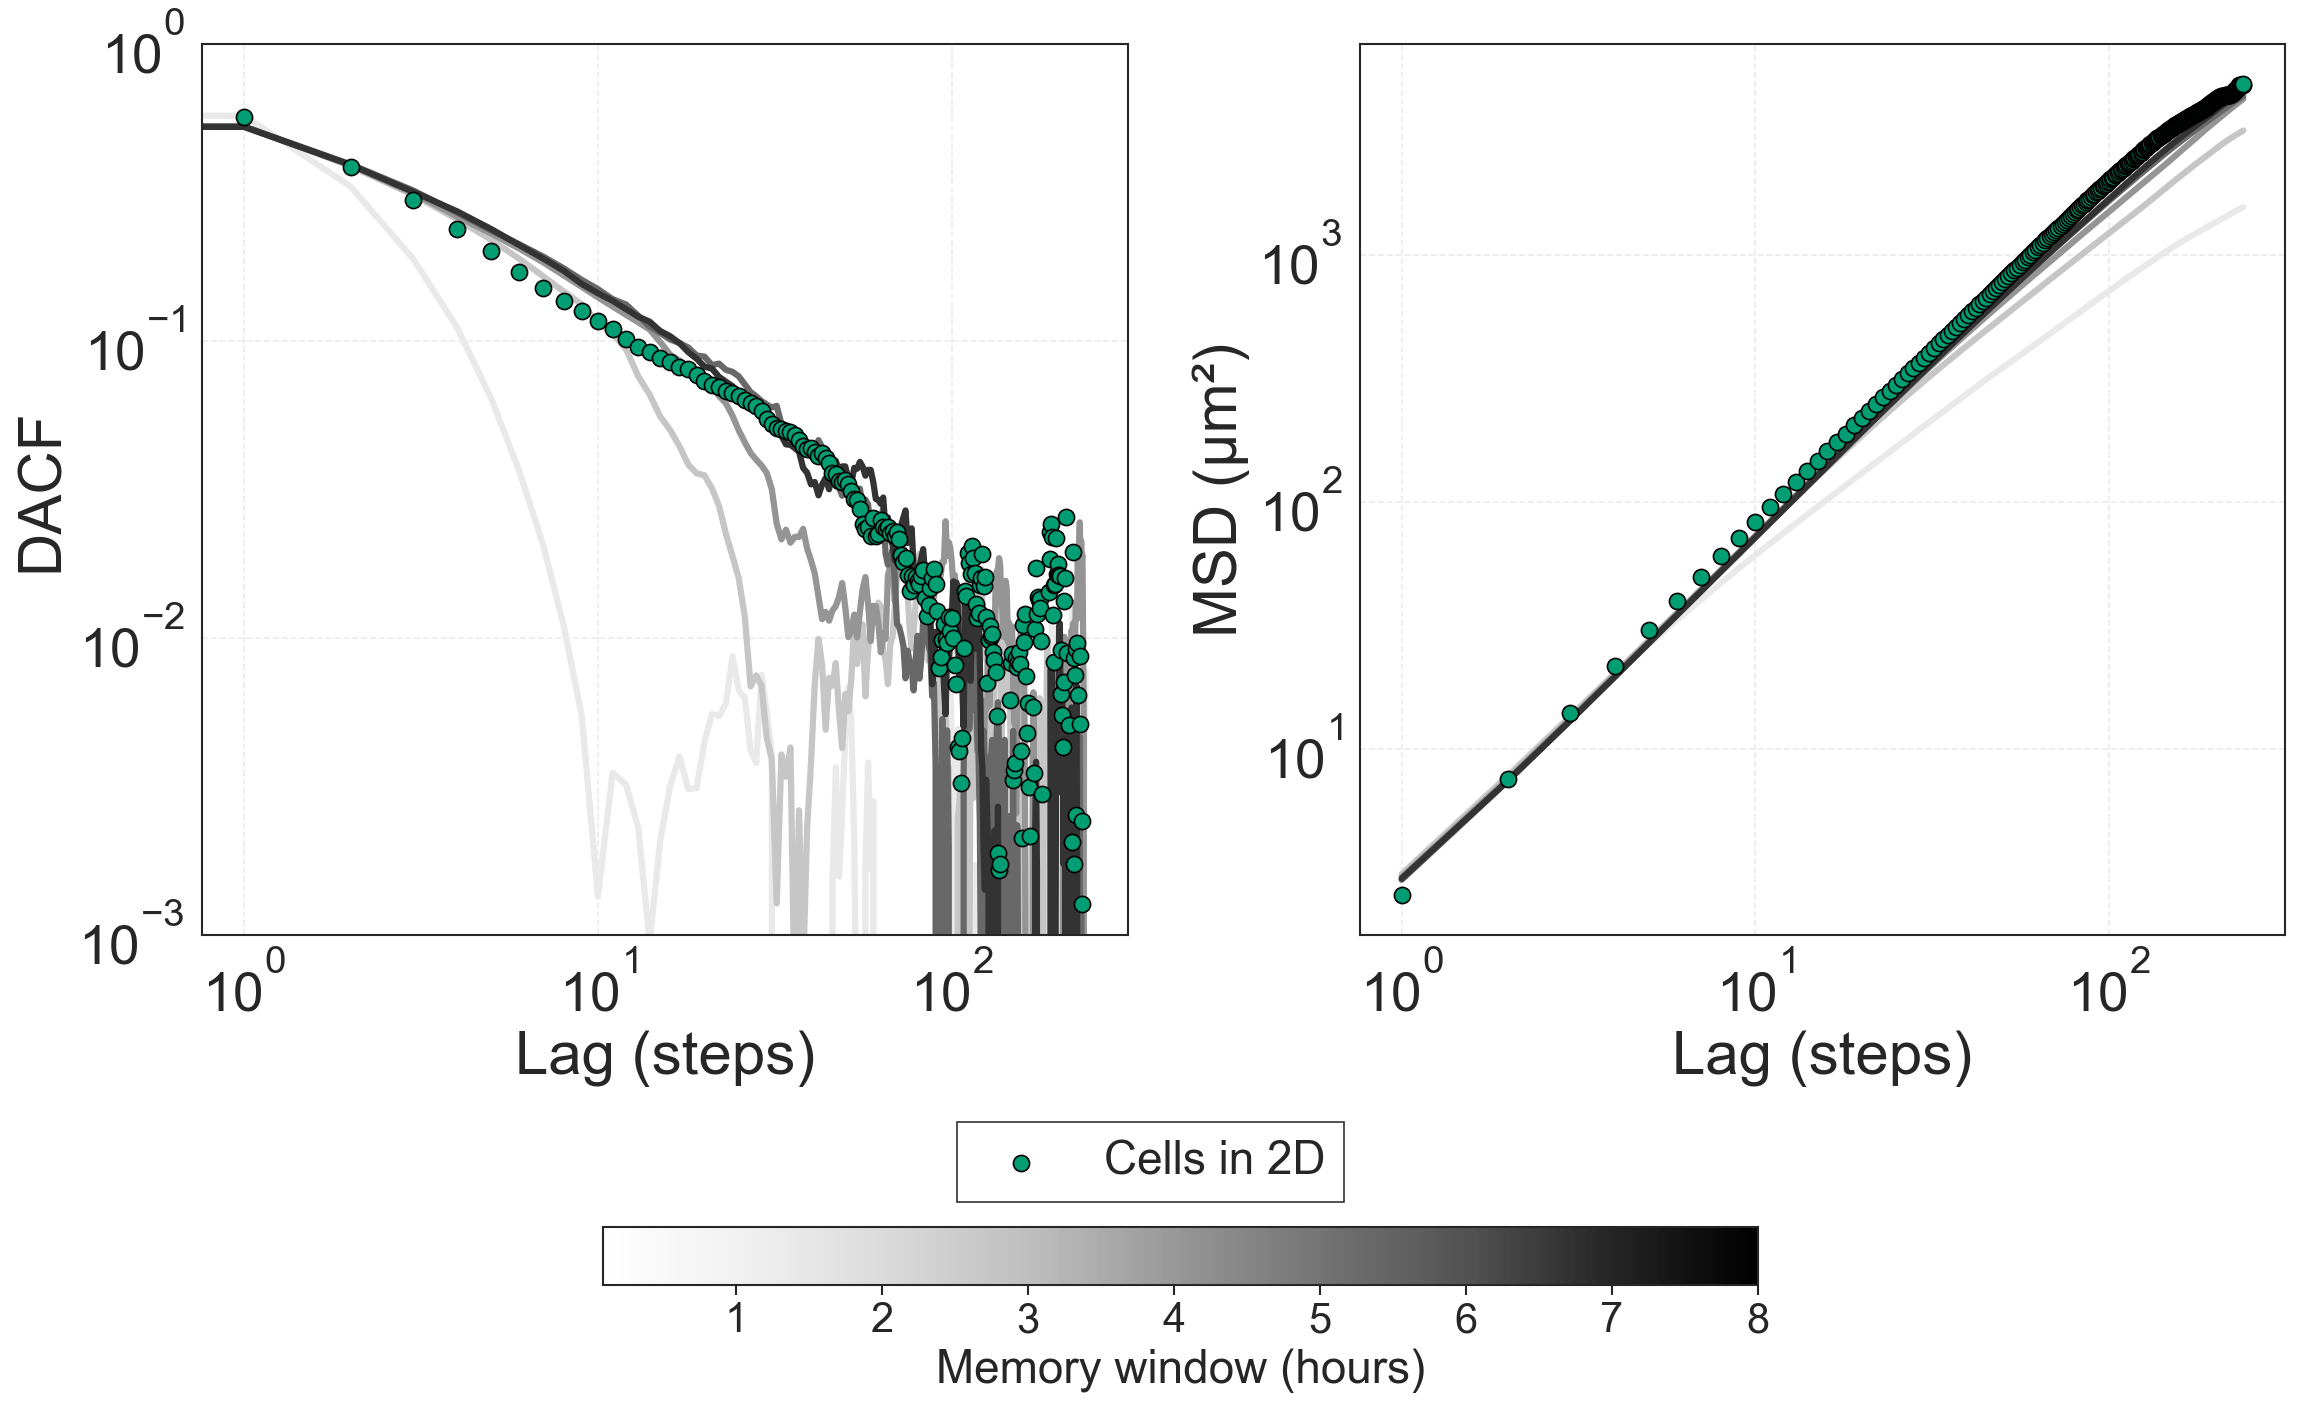

In [ ]:
import matplotlib as mpl

points_to_plot = 240  # number of points to show for clarity
palette = sns.color_palette("Greys", len(memory_windows))

fig, axes = plt.subplots(1, 2, figsize=(16, 10), dpi=150)

# =========================================================
# DACF plot
# =========================================================
axes[0].scatter(dacf_exp['lag'][:points_to_plot], dacf_exp['dacf_mean'][:points_to_plot],
                label='Cells in 2D', color=color_map["2D BTrack Tracking"], s=60, zorder=3, edgecolor='black')

for i, w in enumerate(memory_windows):
    d = results[w]['dacf']
    axes[0].plot(d['lag'][:points_to_plot], d['dacf'][:points_to_plot],
                 color=palette[i], linewidth=3, zorder=2)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim(1e-3, 1)   
axes[0].set_xlabel('Lag (steps)')
axes[0].set_ylabel('DACF')
# axes[0].set_title('Directional Autocorrelation — effect of memory window')
axes[0].grid(True, linestyle='--', alpha=0.4)
# axes[0].legend(['FACSed DE on laminin'], loc='lower left', frameon=True, fontsize=20, edgecolor='black', fancybox=False, framealpha=1)

# =========================================================
# MSD plot
# =========================================================
axes[1].scatter(msd_exp['lag'][:points_to_plot], msd_exp['msd_mean'][:points_to_plot],
                label='FACSed DE on laminin', color=color_map["2D BTrack Tracking"], s=60, zorder=3, edgecolor='black')

for i, w in enumerate(memory_windows):
    m = results[w]['msd']
    axes[1].plot(m['lag'][:points_to_plot], m['msd'][:points_to_plot],
                 color=palette[i], linewidth=3, zorder=2)

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Lag (steps)')
axes[1].set_ylabel('MSD (μm²)')
# axes[1].set_title('Mean Squared Displacement — effect of memory window')
axes[1].grid(True, linestyle='--', alpha=0.4)
# axes[1].legend(['FACSed DE on laminin'], loc='lower left', frameon=True, fontsize=20, edgecolor='black', fancybox=False, framealpha=1)

# =========================================================
# Shared colorbar for memory window values
# =========================================================
# Create a ScalarMappable for colorbar
memory_windows_arr = np.array(memory_windows)
norm = mpl.colors.Normalize(vmin=min(memory_windows_arr/12), vmax=max(memory_windows_arr/12)) # normalize to hours assuming 1 step = 5 minutes
sm = mpl.cm.ScalarMappable(cmap=mpl.cm.Greys, norm=norm)
sm.set_array([])

# --- Legend: place above colorbar ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.15),  # move legend upward
    ncol=len(labels),            # horizontal layout
    fontsize=22,
    frameon=True,
    edgecolor='black',
    fancybox=False,
)

# --- Colorbar: move a bit lower ---
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal',
                    fraction=0.05, pad=0.25)  # pad increases distance from plots
cbar.set_label('Memory window (hours)', fontsize=22)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0.3, 1, 1])  # leave space for both
plt.show()

Note: memory window 1: 1 zero-lag points skipped for log-x.
Note: memory window 12: 1 zero-lag points skipped for log-x.
Note: memory window 24: 1 zero-lag points skipped for log-x.
Note: memory window 48: 1 zero-lag points skipped for log-x.
Note: memory window 96: 1 zero-lag points skipped for log-x.


C:\Users\davidzi\AppData\Local\Temp\ipykernel_22608\434295445.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.3, 1, 1])


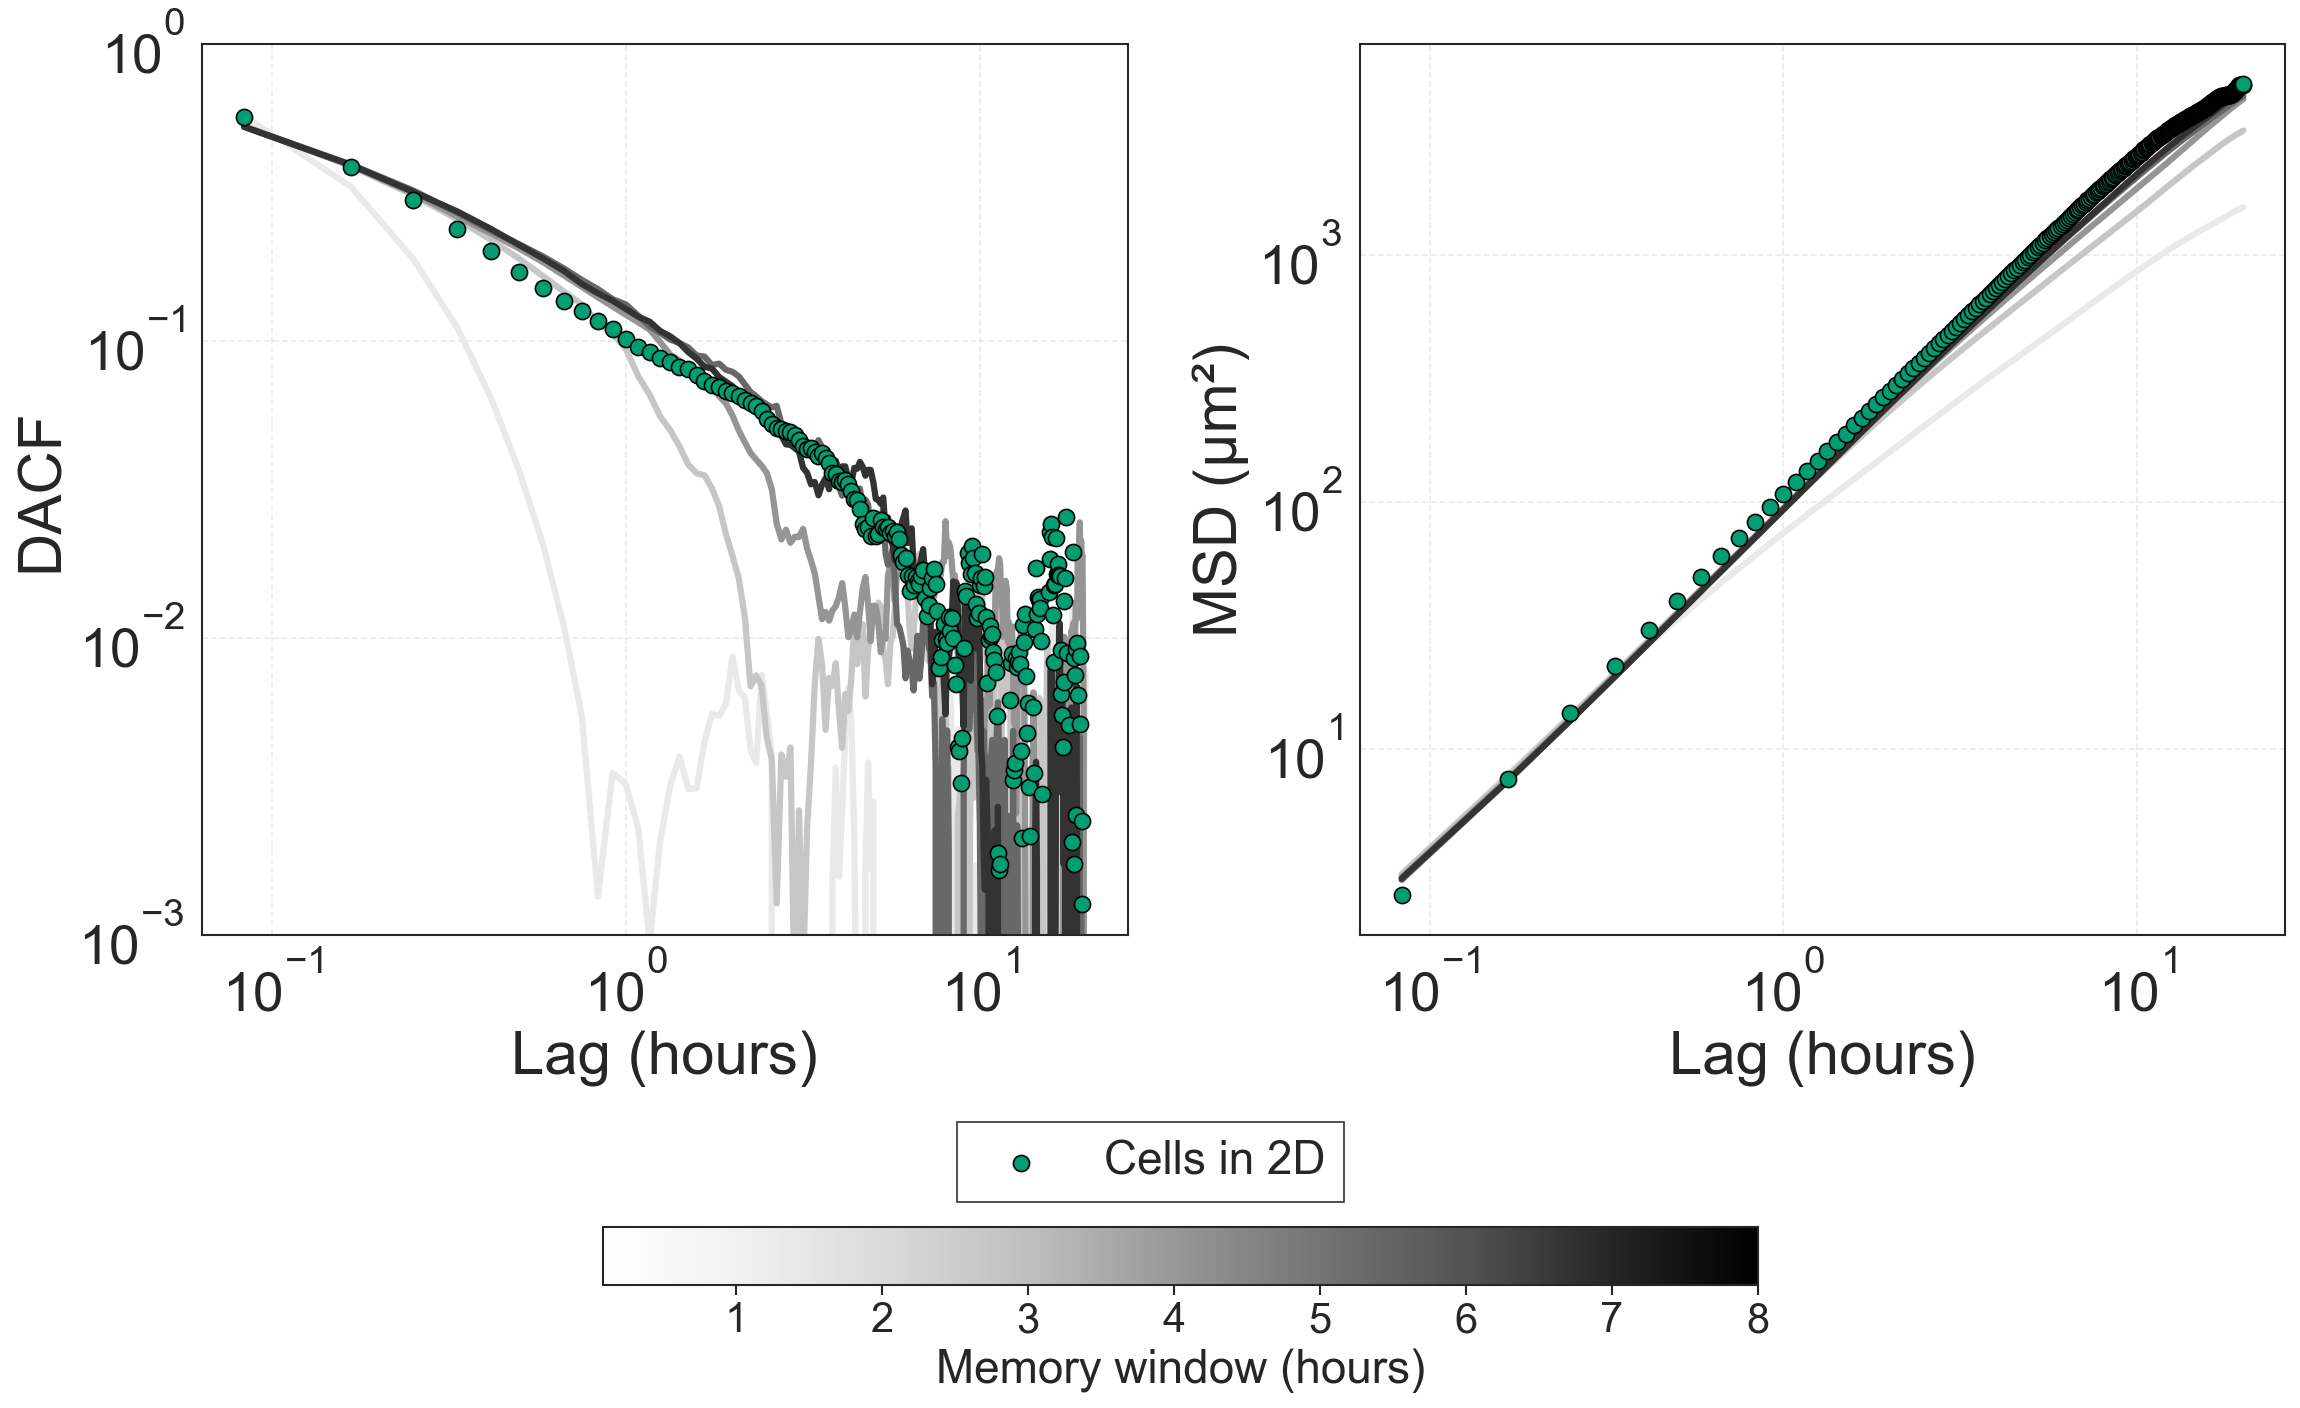

In [ ]:

points_to_plot = 240  # number of points to show for clarity
palette = sns.color_palette("Greys", len(memory_windows))

fig, axes = plt.subplots(1, 2, figsize=(16, 10), dpi=150)

# conversion: 1 step = 5 minutes -> hours = steps * 5 / 60 = steps / 12
step_to_hours = 1.0 / 12.0

# =========================================================
# DACF plot (x axis in hours)
# =========================================================
# convert experimental dt to hours and filter zeros for log scale
dacf_lag_hours = np.asarray(dacf_exp['lag'][:points_to_plot].astype(float)) * step_to_hours
mask_nonzero = dacf_lag_hours > 0
if not mask_nonzero.all():
    num_dropped = (~mask_nonzero).sum()
    print(f"Warning: {num_dropped} DACF points with lag==0 were removed for log-x plotting.")

axes[0].scatter(dacf_lag_hours[mask_nonzero],
                dacf_exp['dacf_mean'][:points_to_plot].values[mask_nonzero],
                label='Cells in 2D',
                color=color_map["2D BTrack Tracking"],
                s=60, zorder=3, edgecolor='black')

for i, w in enumerate(memory_windows):
    d = results[w]['dacf']
    lag_hours_sim = np.asarray(d['lag'][:points_to_plot].astype(float)) * step_to_hours
    # mask zeros for plotting on log axis
    mask_sim = lag_hours_sim > 0
    if not mask_sim.all():
        # don't print every time; aggregate minimal info
        print(f"Note: memory window {w}: {np.sum(~mask_sim)} zero-lag points skipped for log-x.")
    axes[0].plot(lag_hours_sim[mask_sim], d['dacf'][:points_to_plot].values[mask_sim],
                 color=palette[i], linewidth=3, zorder=2)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim(1e-3, 1)
axes[0].set_xlabel('Lag (hours)')
axes[0].set_ylabel('DACF')
axes[0].grid(True, linestyle='--', alpha=0.4)

# =========================================================
# MSD plot (x axis in hours)
# =========================================================
msd_lag_hours = np.asarray(msd_exp['lag'][:points_to_plot].astype(float)) * step_to_hours
mask_nonzero_msd = msd_lag_hours > 0
if not mask_nonzero_msd.all():
    print(f"Warning: {np.sum(~mask_nonzero_msd)} MSD points with lag==0 were removed for log-x plotting.")

axes[1].scatter(msd_lag_hours[mask_nonzero_msd],
                msd_exp['msd_mean'][:points_to_plot].values[mask_nonzero_msd],
                label='FACSed DE on laminin',
                color=color_map["2D BTrack Tracking"],
                s=60, zorder=3, edgecolor='black')

for i, w in enumerate(memory_windows):
    m = results[w]['msd']
    lag_hours_sim = np.asarray(m['lag'][:points_to_plot].astype(float)) * step_to_hours
    mask_sim = lag_hours_sim > 0
    axes[1].plot(lag_hours_sim[mask_sim], m['msd'][:points_to_plot].values[mask_sim],
                 color=palette[i], linewidth=3, zorder=2)

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Lag (hours)')
axes[1].set_ylabel('MSD (μm²)')
axes[1].grid(True, linestyle='--', alpha=0.4)

# =========================================================
# Shared colorbar for memory window values (already normalized to hours)
# =========================================================
memory_windows_arr = np.array(memory_windows)
# normalizing to hours: divide by 12 (since memory_windows are in steps)
norm = mpl.colors.Normalize(vmin=(memory_windows_arr/12.0).min(), vmax=(memory_windows_arr/12.0).max())
sm = mpl.cm.ScalarMappable(cmap=mpl.cm.Greys, norm=norm)
sm.set_array([])

# --- Legend above colorbar ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.15),
    ncol=len(labels),
    fontsize=22,
    frameon=True,
    edgecolor='black',
    fancybox=False,
)

# --- Colorbar ---
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Memory window (hours)', fontsize=22)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0.3, 1, 1])
plt.show()

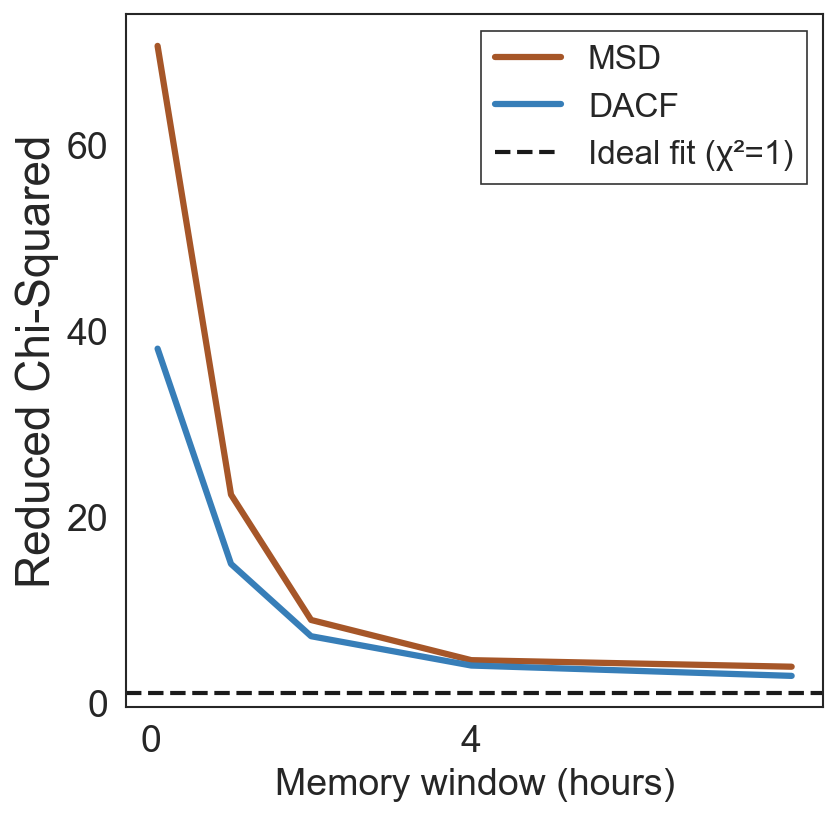

In [ ]:
from fit import reduced_chi_squared
# Calculate reduced chi-squared for each memory window
chi2_results = []
steps_to_compare = 200
for w in memory_windows:
    d = results[w]['dacf']
    m = results[w]['msd']
    chi2_dacf = reduced_chi_squared(dacf_exp['dacf_mean'][:steps_to_compare], d['dacf'][:steps_to_compare], dacf_exp['dacf_sem'][:steps_to_compare])
    chi2_msd = reduced_chi_squared(msd_exp['msd_mean'][:steps_to_compare], m['msd'][:steps_to_compare], msd_exp['msd_sem'][:steps_to_compare])
    chi2_results.append({'memory_window': w, 'chi2_dacf': chi2_dacf, 'chi2_msd': chi2_msd})
chi2_df = pd.DataFrame(chi2_results)
# Plot chi-squared vs memory window
plt.figure(figsize=(6, 6), dpi=150)
plt.plot(chi2_df['memory_window'], chi2_df['chi2_msd'], marker='', label='MSD', linewidth=3, color='#a65628', markersize=8)
plt.plot(chi2_df['memory_window'], chi2_df['chi2_dacf'], marker='', label='DACF', linewidth=3, color='#377eb8', markersize=8)
plt.axhline(1, color='k', linestyle='--', label='Ideal fit (χ²=1)', linewidth=2)
plt.xlabel('Memory Window (hours)', fontsize=22)
plt.ylabel('Reduced Chi-Squared', fontsize=22)

# Each step = 5 minutes
step_minutes = 5
step_hours = step_minutes / 60

# Choose tick positions: every 5 hours
tick_interval_hours = 4
tick_interval_steps = tick_interval_hours / step_hours  # steps between ticks

# Select tick positions and labels
xticks = np.arange(0, chi2_df['memory_window'].max(), tick_interval_steps)
xtick_labels = (xticks * step_hours).round(1)  # convert to hours

plt.xticks(ticks=xticks, labels=[f"{x:g}" for x in (xticks * step_hours)], fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Memory window (hours)", fontsize=18)

# plt.title('Reduced Chi-Squared vs Memory Window')
plt.legend(frameon=True, edgecolor='black', fancybox=False, fontsize=16)
plt.show()

In [ ]:
50*5/60

4.166666666666667

In [ ]:
chi2_df

,memory_window,chi2_dacf,chi2_msd
0,1,38.100242,70.702968
1,12,14.922250,22.385833
2,24,7.132954,8.881876
3,48,3.975552,4.554904
4,96,2.862432,3.848819


In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Basics

In [ ]:
# Demonstration: run three simulations (RW, PRW, BPRW) and plot DACF + MSD in one figure.
# Relies on Simulation, calculate_autocorrelation, calculate_msd, color_map, vonmises_params, shape, loc, scale already available.

# Simulation parameters
n_cells_demo = 200 if 'n_cells' not in globals() else n_cells
n_steps_demo = 240 if 'n_steps' not in globals() else n_steps
time_step_demo = 5 if 'time_step' not in globals() else time_step
velocity_params_demo = {'shape': shape, 'loc': loc, 'scale': scale}

modes = {
    'RW (random)': dict(mode='random', persistence=None, chemotaxis_strength=0.0, vonmises_params=None),
    'PRW (persistent)': dict(mode='persistent', persistence=0.7, chemotaxis_strength=0.0, vonmises_params=None),
    'BPRW (biased persistent)': dict(mode='biased_persistent', persistence=0.7, chemotaxis_strength=0.3, vonmises_params=None),
}

sims = {}
for name, opts in modes.items():
    sim_obj = Simulation(
        n_cells=n_cells_demo,
        time_step=time_step_demo,
        stadium_L=800,
        stadium_R=200,
        source_length=400,
        chemotaxis_strength=opts['chemotaxis_strength'],
        repulsion_strength=0.0,
        interaction_radius=0.0,
        velocity_params=velocity_params_demo,
        persistence=opts['persistence'],
        starting_positions='perimeter',
        mode=opts['mode'],
        memory_window=None,
        memory_exp_lambda=None,
        memory_power_alpha=None,
        vonmises_params=opts['vonmises_params']
    )
    print(f"Running {name} ...")
    sim_obj.run(n_steps=n_steps_demo)
    sim_df_local = sim_obj.get_dataframe()
    sims[name] = {
        'sim': sim_obj,
        'df': sim_df_local,
        'dacf': calculate_autocorrelation(sim_df_local),
        'msd': calculate_msd(sim_df_local, x_col='x', y_col='y')
    }

Running RW (random) ...
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


d:\David\THESIS\simulation\MCmigrate\analysis.py:57: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(norm_dot)
c:\Users\davidzi\AppData\Local\anaconda3\envs\simulations-env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running PRW (persistent) ...
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


d:\David\THESIS\simulation\MCmigrate\analysis.py:57: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(norm_dot)
c:\Users\davidzi\AppData\Local\anaconda3\envs\simulations-env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Running BPRW (biased persistent) ...
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


d:\David\THESIS\simulation\MCmigrate\analysis.py:57: RuntimeWarning: Mean of empty slice
  acorr_vals[dt] = np.nanmean(norm_dot)
c:\Users\davidzi\AppData\Local\anaconda3\envs\simulations-env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


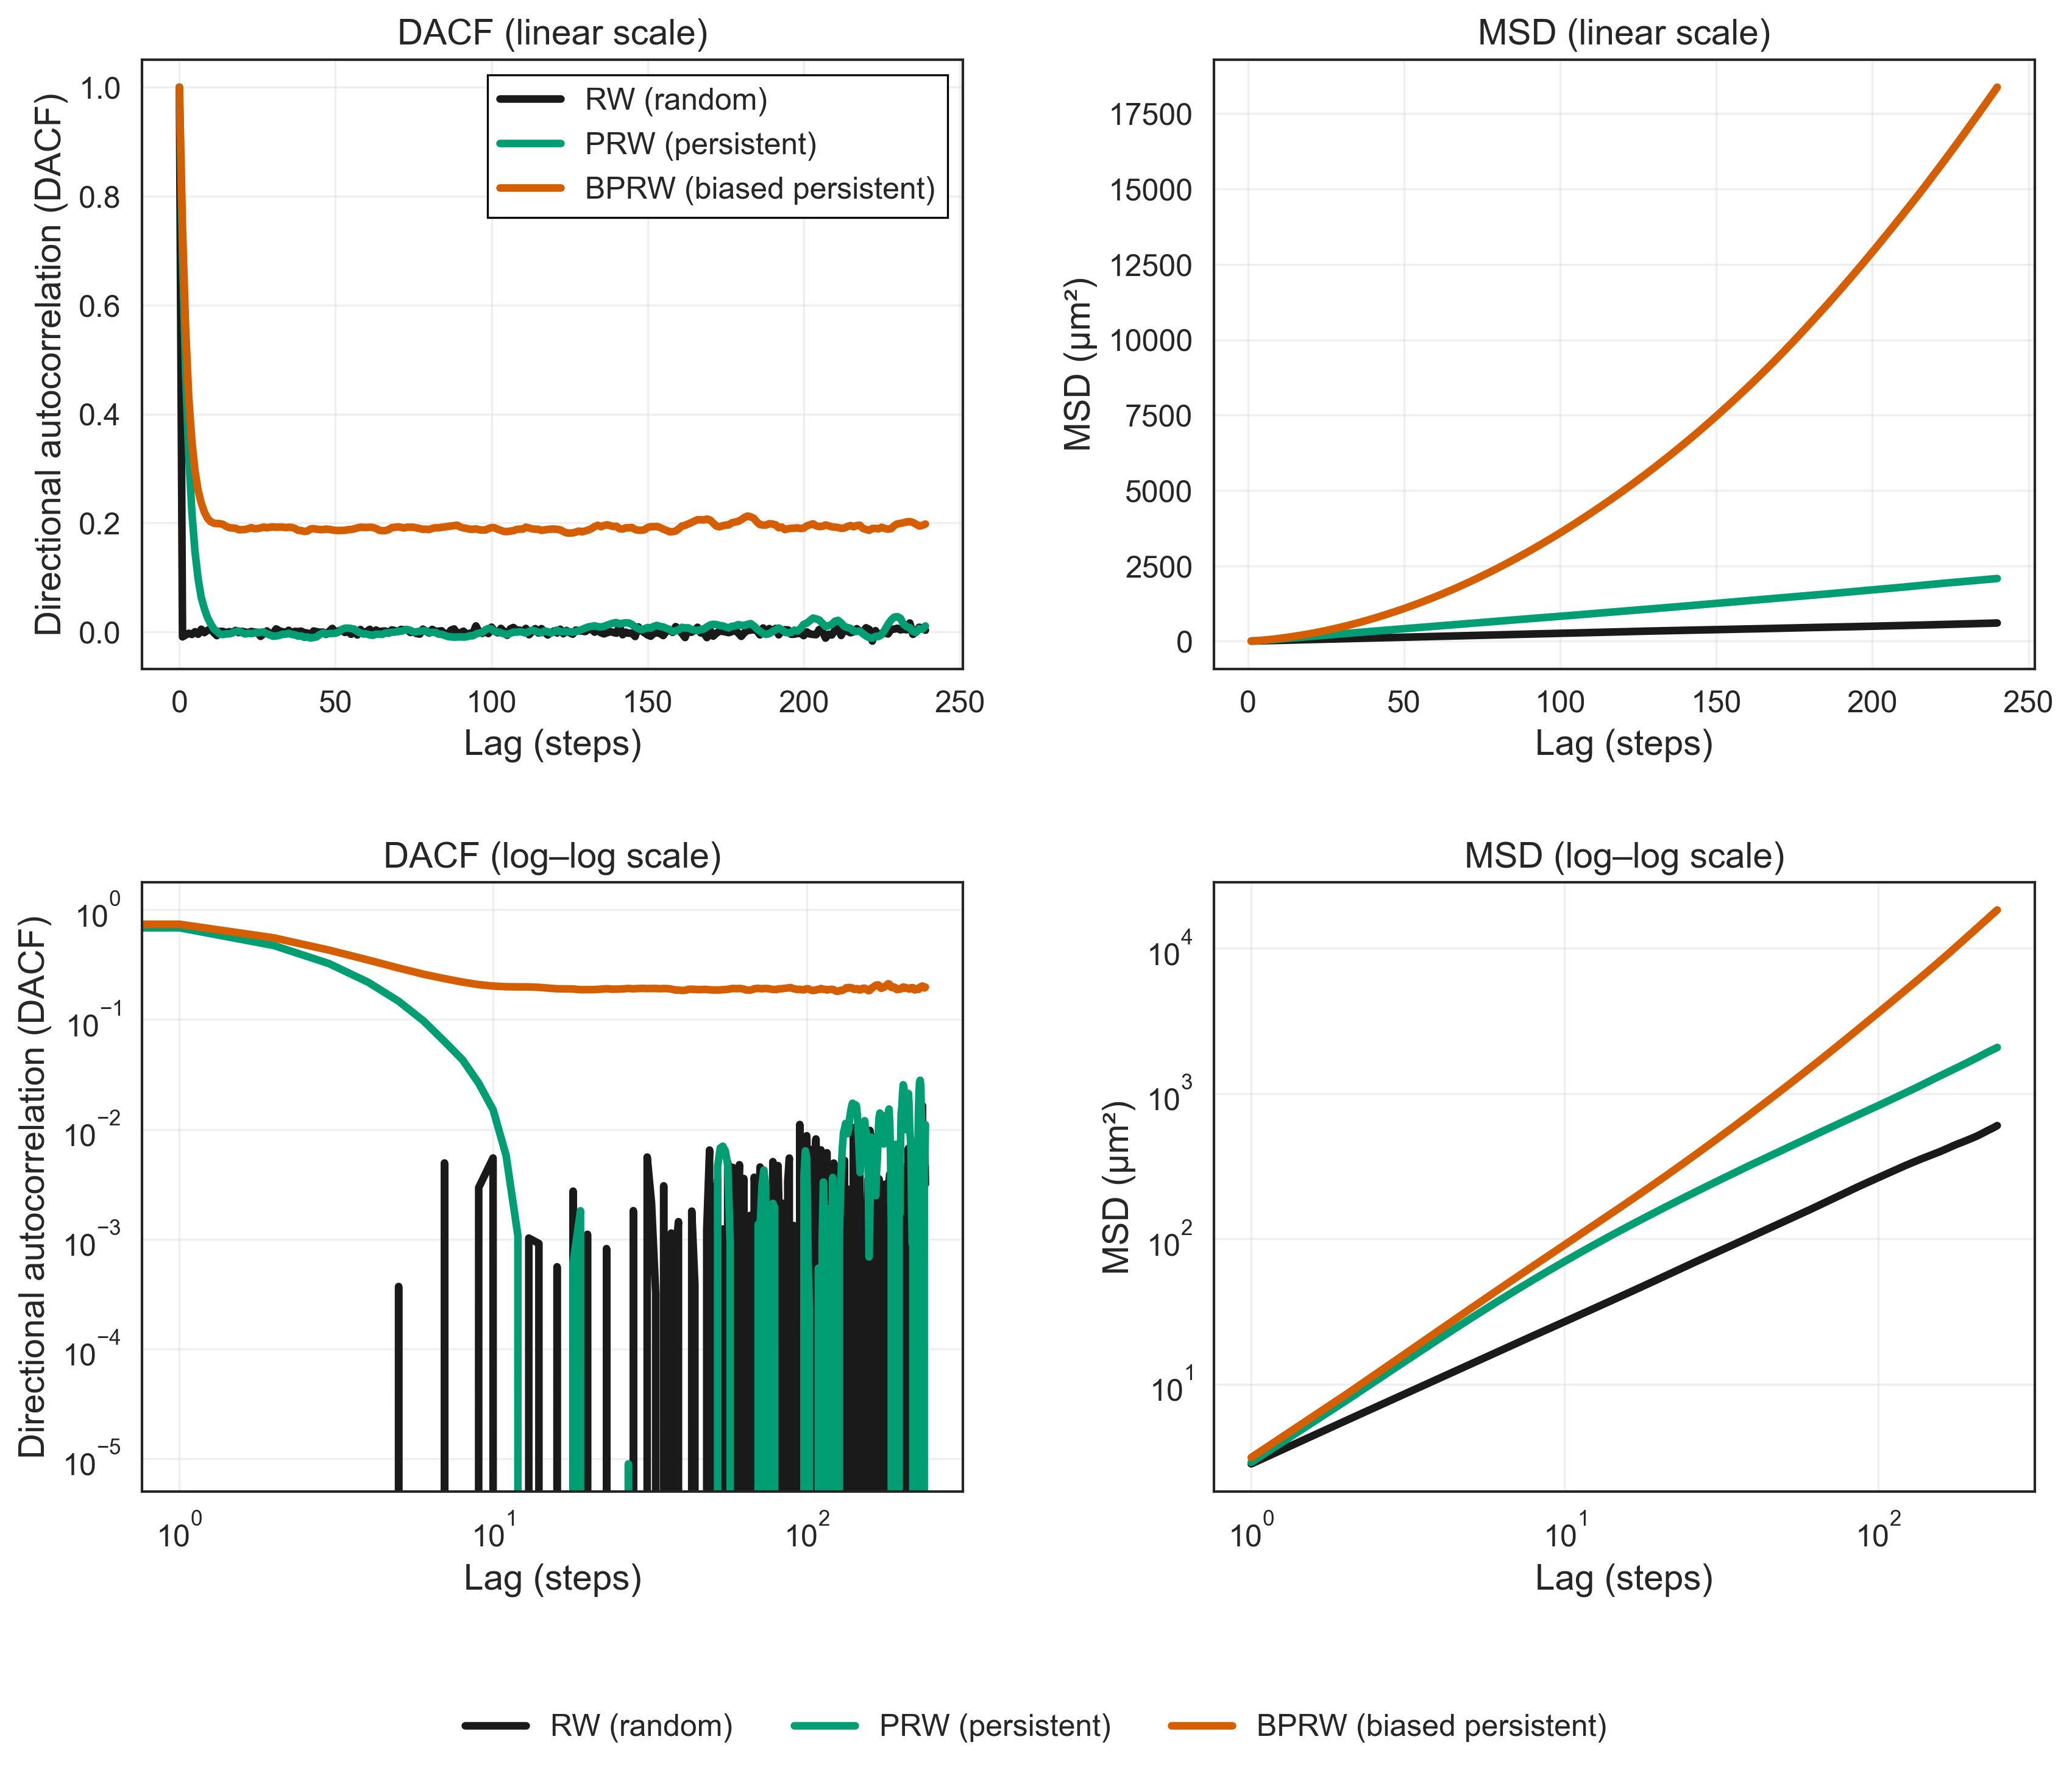

In [ ]:
# Plot DACF and MSD in one figure (linear + log-log)
pts = 60 if 'points_to_plot' not in globals() else points_to_plot

# Create a 2x2 grid: [DACF-linear, MSD-linear; DACF-loglog, MSD-loglog]
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=300)

colors_demo = ["k", color_map["2D BTrack Tracking"], color_map["3D BTrack Tracking"]]

# -----------------------------
# Row 1: Linear scale
# -----------------------------

# DACF (linear)
for (name, entry), c in zip(sims.items(), colors_demo):
    d = entry['dacf']
    axes[0, 0].plot(d['lag'][:pts], d['dacf'][:pts], marker='', linestyle='-', label=name, color=c, linewidth=3)
axes[0, 0].set_xlabel('Lag (steps)', fontsize=14)
axes[0, 0].set_ylabel('Directional autocorrelation (DACF)', fontsize=14)
axes[0, 0].legend(loc='upper right', frameon=True, fontsize=12, edgecolor='black', fancybox=False, framealpha=1)
axes[0, 0].tick_params(axis='both', which='major', labelsize=12)
axes[0, 0].set_title("DACF (linear scale)", fontsize=14)
axes[0, 0].grid(which='major', alpha=0.3)

# MSD (linear)
for (name, entry), c in zip(sims.items(), colors_demo):
    m = entry['msd']
    axes[0, 1].plot(m['lag'][:pts], m['msd'][:pts], marker='', linestyle='-', label=name, color=c, linewidth=3)
axes[0, 1].set_xlabel('Lag (steps)', fontsize=14)
axes[0, 1].set_ylabel('MSD (μm²)', fontsize=14)
axes[0, 1].tick_params(axis='both', which='major', labelsize=12)
axes[0, 1].set_title("MSD (linear scale)", fontsize=14)
axes[0, 1].grid(which='major', alpha=0.3)

# -----------------------------
# Row 2: Log–log scale
# -----------------------------

# DACF (log-log)
for (name, entry), c in zip(sims.items(), colors_demo):
    d = entry['dacf']
    axes[1, 0].plot(d['lag'][:pts], d['dacf'][:pts], marker='', linestyle='-', label=name, color=c, linewidth=3)
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Lag (steps)', fontsize=14)
axes[1, 0].set_ylabel('Directional autocorrelation (DACF)', fontsize=14)
axes[1, 0].tick_params(axis='both', which='major', labelsize=12)
axes[1, 0].set_title("DACF (log–log scale)", fontsize=14)
axes[1, 0].grid(which='major', alpha=0.3)

# MSD (log-log)
for (name, entry), c in zip(sims.items(), colors_demo):
    m = entry['msd']
    axes[1, 1].plot(m['lag'][:pts], m['msd'][:pts], marker='', linestyle='-', label=name, color=c, linewidth=3)
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel('Lag (steps)', fontsize=14)
axes[1, 1].set_ylabel('MSD (μm²)', fontsize=14)
axes[1, 1].tick_params(axis='both', which='major', labelsize=12)
axes[1, 1].set_title("MSD (log–log scale)", fontsize=14)
axes[1, 1].grid(which='major', alpha=0.3)

# -----------------------------
# Layout and legend
# -----------------------------
# Shared legend (optional, cleaner)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(colors_demo), fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave room for shared legend
plt.show()


In [ ]:
sims.items()

dict_items([('RW (random)', {'sim': <simulation.Simulation object at 0x000001EF0F98B6D0>, 'df':        track_id  step     t           x           y       v_x       v_y
0             0     0     0  200.000000 -400.000000  0.000000  0.000000
1             0     1     5  199.590587 -399.729297 -0.409413  0.270703
2             0     2    10  200.000000 -399.969346  0.409413 -0.240049
3             0     3    15  200.000000 -399.902717  0.000000  0.066629
4             0     4    20  199.999925 -400.172729 -0.000075 -0.270013
...         ...   ...   ...         ...         ...       ...       ...
57995       199   285  1425  171.340306 -417.352507  0.037775  0.284928
57996       199   286  1430  170.841045 -416.569064 -0.499261  0.783443
57997       199   287  1435  172.199901 -419.115037  1.358856 -2.545972
57998       199   288  1440  171.805928 -419.425930 -0.393973 -0.310893
57999       199   289  1445  172.068209 -419.131087  0.262281  0.294843

[58000 rows x 7 columns], 'dacf':      

C:\Users\davidzi\AppData\Local\Temp\ipykernel_22608\141708142.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space for shared legend


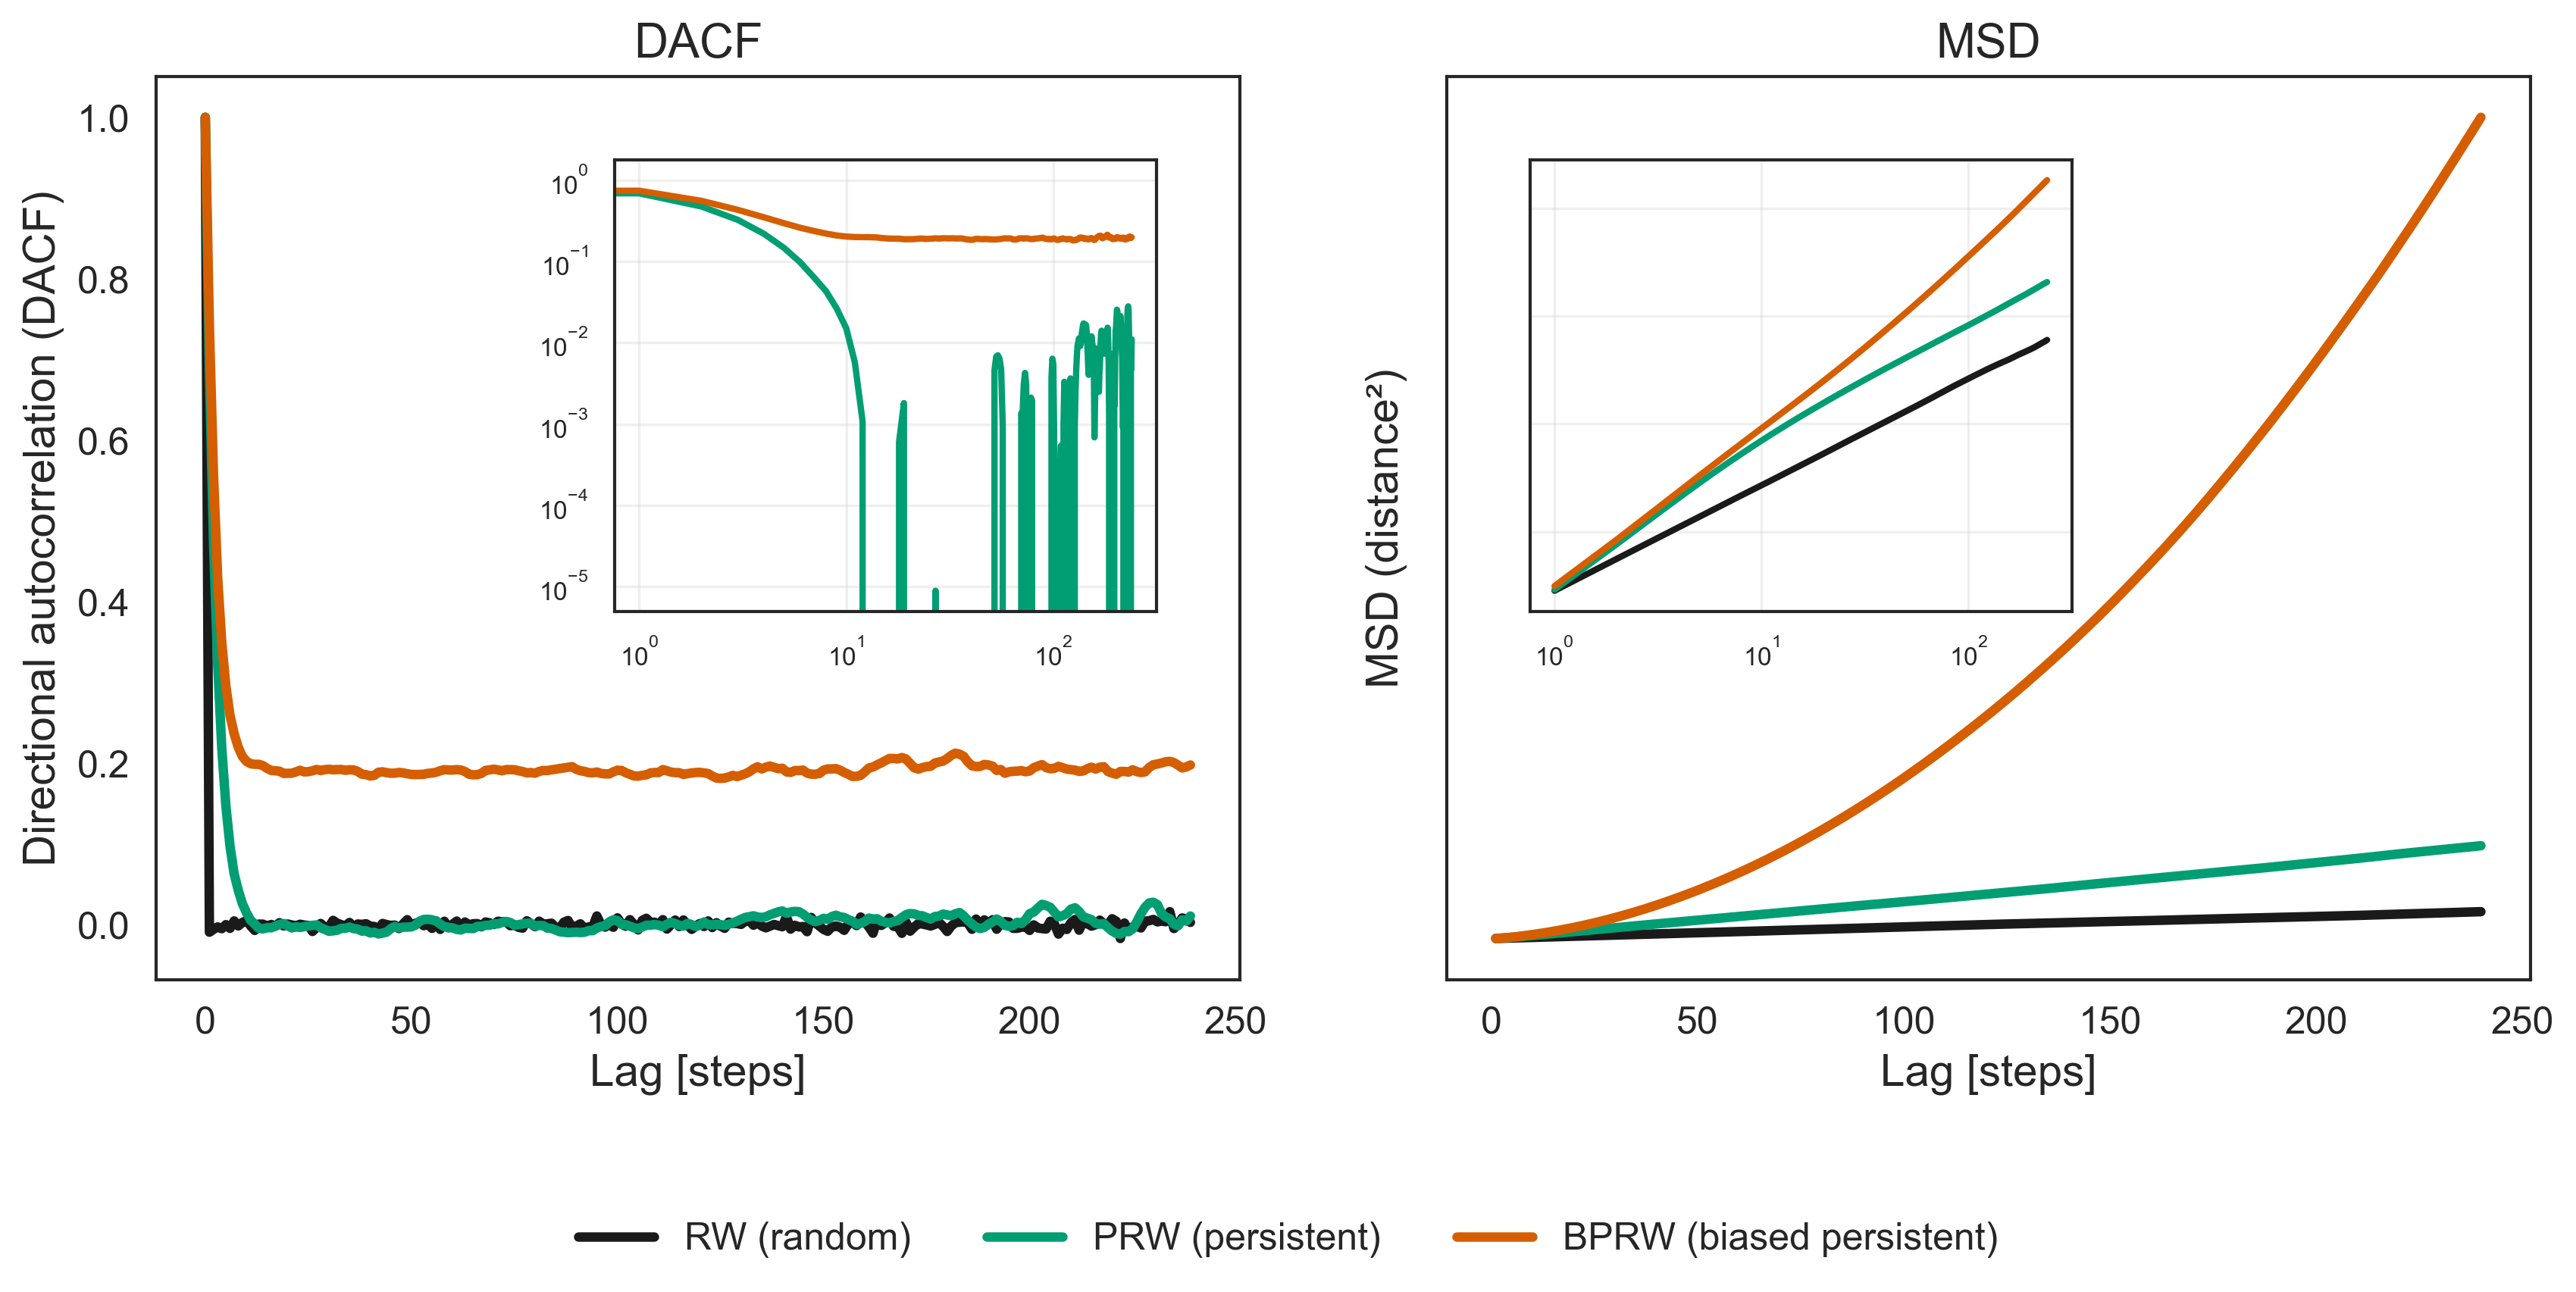

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pts = 60 if 'points_to_plot' not in globals() else points_to_plot

# Main figure with two panels
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

colors_demo = ["k", color_map["2D BTrack Tracking"], color_map["3D BTrack Tracking"]]

# =========================================================
# DACF main plot (linear) + inset (log–log, upper right)
# =========================================================
ax_main = axes[0]
ax_inset = inset_axes(ax_main, width="50%", height="50%", loc="upper right", borderpad=1)

for (name, entry), c in zip(sims.items(), colors_demo):
    d = entry['dacf']
    # Main (linear)
    ax_main.plot(d['lag'][:pts], d['dacf'][:pts], color=c, linewidth=3, label=name)
    # Inset (log–log) (without RW, which isn't visible there)
    if name != "RW (random)":
        ax_inset.plot(d['lag'][:pts], d['dacf'][:pts], color=c, linewidth=2)

# Main DACF setup
ax_main.set_xlabel('Lag [steps]', fontsize=14)
ax_main.set_ylabel('Directional autocorrelation (DACF)', fontsize=14)
ax_main.tick_params(axis='both', which='major', labelsize=12)
ax_main.set_title("DACF", fontsize=15)
# ax_main.grid(alpha=0.3)

# Inset DACF setup
ax_inset.set_xscale('log')
ax_inset.set_yscale('log')
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.grid(alpha=0.3)

# =========================================================
# MSD main plot (linear) + inset (log–log, upper left)
# =========================================================
ax_main = axes[1]
ax_inset = inset_axes(ax_main, width="50%", height="50%", loc="upper left", borderpad=1)

for (name, entry), c in zip(sims.items(), colors_demo):
    m = entry['msd']
    # Main (linear)
    ax_main.plot(m['lag'][:pts], m['msd'][:pts], color=c, linewidth=3, label=name)
    # Inset (log–log)
    ax_inset.plot(m['lag'][:pts], m['msd'][:pts], color=c, linewidth=2)

# Main MSD setup
ax_main.set_xlabel('Lag [steps]', fontsize=14)
ax_main.set_ylabel('MSD (distance²)', fontsize=14)
# remove ticks for clarity
# ax_main.xaxis.set_major_formatter(plt.NullFormatter())
ax_main.yaxis.set_major_formatter(plt.NullFormatter())
ax_main.tick_params(axis='both', which='major', labelsize=12)
ax_main.set_title("MSD", fontsize=15)
# ax_main.grid(alpha=0.3)

# Inset MSD setup
ax_inset.set_xscale('log')
ax_inset.set_yscale('log')
# remove ticks for clarity
# ax_inset.xaxis.set_major_formatter(plt.NullFormatter())
ax_inset.yaxis.set_major_formatter(plt.NullFormatter())
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.grid(alpha=0.3)

# =========================================================
# Shared legend below both plots
# =========================================================
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(colors_demo),
           fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space for shared legend
plt.show()